# Predictions for Station W14

This notebook is used to make predictions for station W14. 

It includes model hyperparameter optimization, backtesting, and the execution of the prediction pipeline on the official test data.

In [ ]:
import sys
import os
# Add the parent directory to the Python path
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
)

In [1]:
# Import Libraries
import pandas as pd

import importlib
import utils
import modelsW14

2026-01-16 15:05:45.436627: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 15:05:45.485143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 15:05:49.812711: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# In case of 'utils.py' modifications
importlib.reload(utils)

<module 'utils' from '/home/pedoussa/Bureau/PIR 5A _ 15-01-2026/W14/utils.py'>

In [3]:
# In case of 'modelsW14.py' modifications
importlib.reload(modelsW14)

<module 'modelsW14' from '/home/pedoussa/Bureau/PIR 5A _ 15-01-2026/W14/modelsW14.py'>

---

## 1: Prediction on 2022

### 1.1: Prepare Data

In [4]:
# Load Data
x_train = x_train = pd.read_csv('train_f_x.csv')
y_train = pd.read_csv('y_train_sncf.csv')
x_test = pd.read_csv('x_test.csv')

In [5]:
# Data Preparation
df = utils.prepare_backtest_data(x_train, y_train, remove_covid=True)

# Extract only QD6 station data
df_w14 = df['W14'].copy()
print("First Date with validations: ", df_w14['date'].min())
print("Last Date with validations: ", df_w14['date'].max())

# Split into train and test dataset
df_w14_train, df_w14_test = utils.split_dataset(df_w14, cut_date='2022-09-17') # at 2/3 of data points available

First Date with validations:  2022-07-02 00:00:00
Last Date with validations:  2022-12-31 00:00:00


### 1.2: Predictions

#### 1.2.1: Hyperparameter Optimization

In [6]:
# imports
import optuna
import tqdm
from optuna.samplers import TPESampler

/home/pedoussa/.conda/envs/tf311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def objectiveRNN(trial):
    """
    Optuna objective function to minimize the MAPE score for W14 station.
    """
    # Define the search space for hyperparameters
    params = {
        "units": trial.suggest_int("units", 30, 60, step=5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [15, 20, 25, 30, 35, 40]),
        "seq_len": trial.suggest_int("seq_len", 10, 40, step=5)
    }

    # Initialize a fresh prediction DataFrame for this specific trial
    y_trial_placeholder = df_w14_test[['index', 'y']].copy()

    try:
        # Call the backtest function with the suggested parameters
        _, _, mape_results = modelsW14.backtest_prediction(
            df_per_station_train=df_w14_train,
            df_per_station_test=df_w14_test,
            y_predicted_vX=y_trial_placeholder,
            seq_len=params["seq_len"],
            units=params["units"],
            activation='tanh',
            learning_rate=params["learning_rate"],
            batch_size=params["batch_size"],
            epochs=100, 
            early_stop=True,
            architecture='rnn'
        )

        # Extract the MAPE score (index 0 because we only process QD6)
        current_mape = mape_results[0]['MAPE']
        
        # Return the score to Optuna (it will try to minimize this value)
        return current_mape

    except Exception as e:
        # If a specific combination of parameters fails (e.g., OOM or shape error), 
        # we return infinity so Optuna avoids this region.
        print(f"Trial failed with error: {e}")
        return float('inf')

In [8]:
# Run flag
run_flag = 0

In [ ]:
if (run_flag == 1):
    # Create and run the study
    studyRNN = optuna.create_study(direction="minimize")
    studyRNN.optimize(objectiveRNN, n_trials=30)
    print("Optimization Finished!")

    # Increment the run flag
    run_flag+=1

    # Display results
    print(f"Best MAPE: {studyRNN.best_value:.4f}")
    print("Best Hyperparameters for RNN:", studyRNN.best_params)

#### 1.2.2: Predictions

In [ ]:
# Best Hyperparameters for RNN: {'units': 55, 'learning_rate': 0.0004542740230942289, 'batch_size': 15, 'seq_len': 30}
# Best MAPE: 0.68

In [ ]:
# Parameters
units = 55
learning_rate = 0.0004542740230942289
batch_size = 15
seq_len = 30

activation = 'tanh'
epochs = 100
early_stop = True
features = ['job', 'ferie', 'vacances']
architecture = 'rnn'

In [ ]:
# Create a df to store the predictions
y_w14_predicted_rnn = df_w14_test[['index', 'date', 'y']].copy()

In [ ]:
# Run the prediction pipeline
y_w14_predicted_rnn, w14_losses_rnn, qd6_mape_result_rnn = modelsW14.backtest_prediction(df_w14_train,
                                                             df_w14_test,
                                                             y_w14_predicted_rnn,
                                                             seq_len, units, activation, learning_rate, batch_size,
                                                             epochs, early-stop,
                                                             features,
                                                             architecture)

Station W14


I0000 00:00:1768572373.551276  196662 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1063 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9
2026-01-16 15:06:14.651931: I external/local_xla/xla/service/service.cc:163] XLA service 0x48ab7eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-16 15:06:14.651969: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 2000 Ada Generation, Compute Capability 8.9
2026-01-16 15:06:14.671156: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-16 15:06:14.753322: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
I0000 00:00:1768572375.475014  196791 device_compiler.h:196] Compiled cluster using XLA!  This line is log

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


### 1.3: Explore Results

RNN Model
MAPE per station:
  station      MAPE
0     W14  3.072696

Average MAPE over all stations: 3.0727


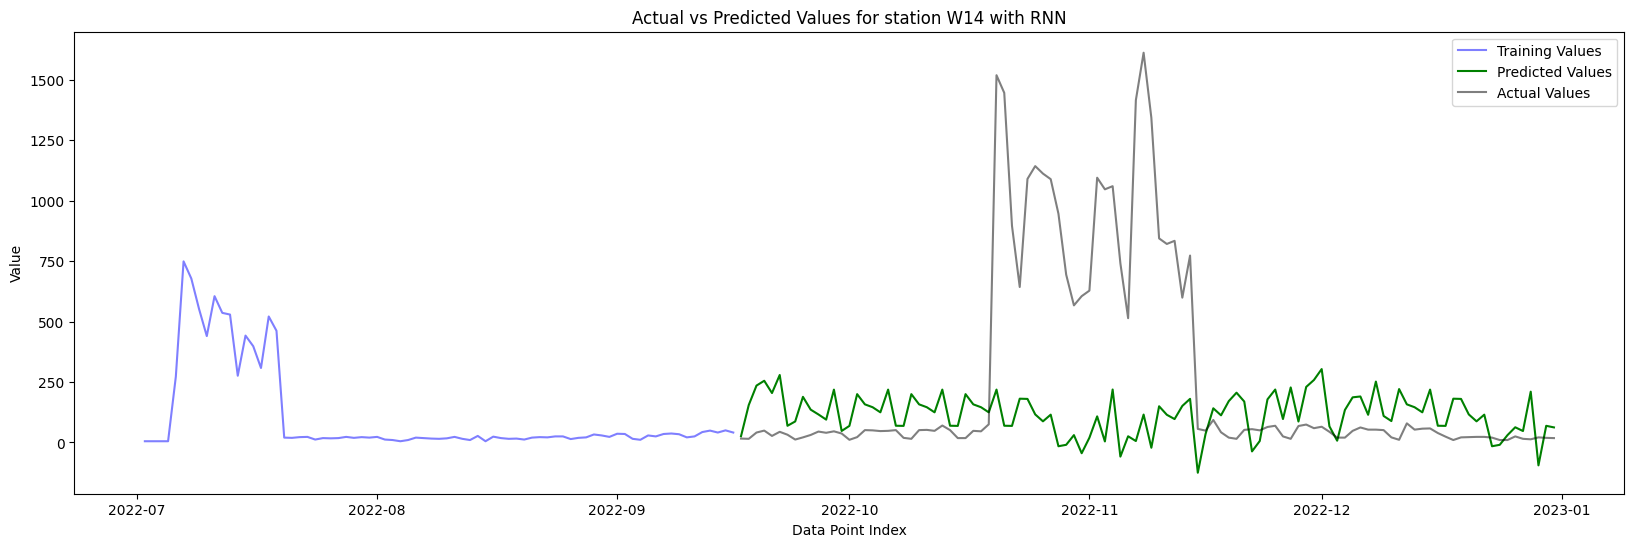

In [14]:
# Show MAPE results
print("RNN Model")
utils.show_mape_results(qd6_mape_result_rnn)

# Show predictions
modelsW14.show_predictions_results_one_station(df_w14_train, y_w14_predicted_rnn, df_w14_test, 'W14', 'RNN')

## 2: Prediction on 2023

### 2.1: Prepare Data

In [15]:
# Load Data
x_train = x_train = pd.read_csv('train_f_x.csv')
y_train = pd.read_csv('y_train_sncf.csv')
x_test = pd.read_csv('x_test.csv')

In [16]:
# Prepare data
df_train, df_test = utils.prepare_submission_data(x_train, y_train, x_test, remove_covid=True)

# Extract only W14 station data
df_w14_train = df_train['W14'].copy()
df_w14_test = df_test['W14'].copy()

print("First Date to predict: ", df_w14_test['date'].min())
print("Last Date to predict: ", df_w14_test['date'].max())

First Date to predict:  2023-01-01 00:00:00
Last Date to predict:  2023-06-30 00:00:00


In [ ]:
# Create a df to store the predictions
y_attempt = df_w14_test[['index', 'date', 'y']].copy()

### 2.2: Predictions

In [ ]:
# Parameters
units = 55
learning_rate = 0.0004542740230942289
batch_size = 15
seq_len = 30

activation = 'tanh'
epochs = 100
early_stop = True
features = ['job', 'ferie', 'vacances']
architecture = 'rnn'

In [ ]:
# Run the prediction pipeline
y_predicted, qd6_losses = modelsW14.submission_prediction(df_w14_train, df_w14_test, y_attempt,
                                                           seq_len, units, activation, learning_rate, batch_size,
                                                           epochs, early_stop,
                                                           features,
                                                           architecture)

Station W14
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


### 2.3: Explore Results

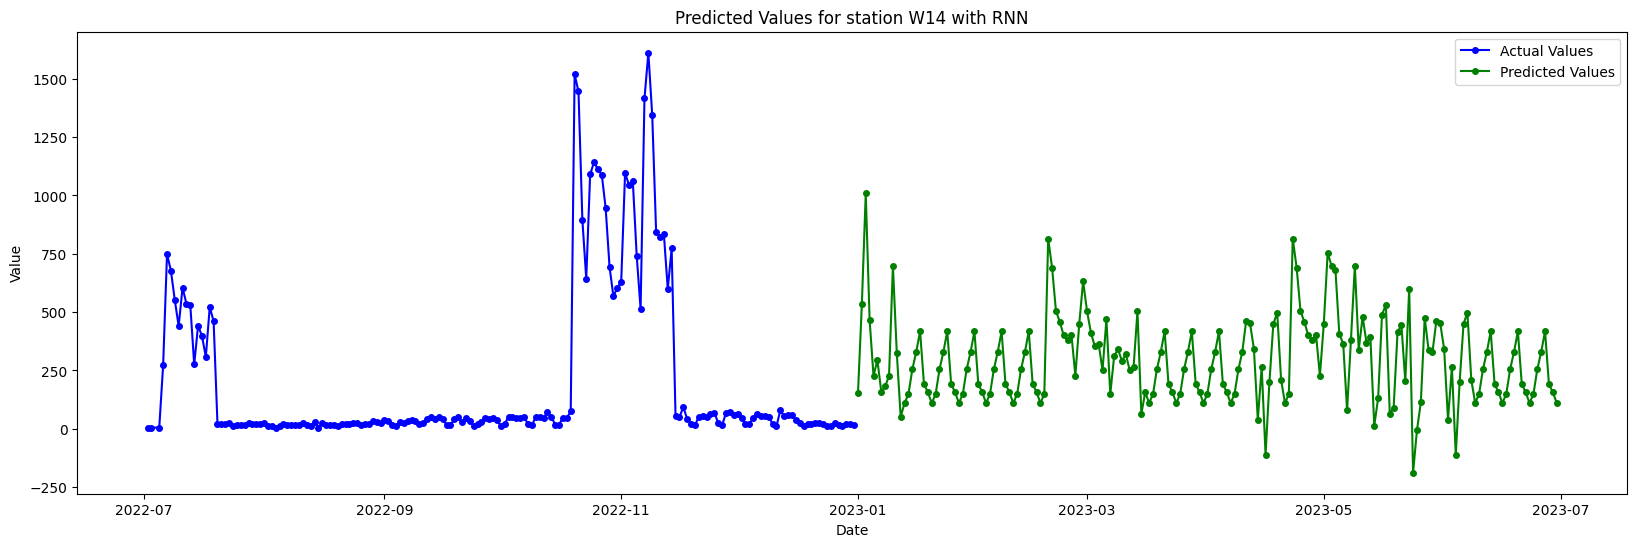

In [20]:
modelsW14.show_prediction(df_w14_train, y_predicted, 'W14', 'RNN', start_date='2015-01-01')

In [ ]:
# Export the predicted values to a CSV file
# y_predicted.to_csv('W14predictions.csv')